# Wstęp

Analiza składowych niezależnych (*independent component analysis*, ICA) jest wykorzystywana do ślepej separacji źródeł, a w przypadku akustyki - ślepej separacji źródeł dźwięku. Metoda zakłada, że obserwowany sygnał jest liniową kombinacją kilku źródeł dźwięku, które są statystycznie niezależne. Najczęściej stosuje się ją do wyodrębniania mówców z sygnału zawierającego kilka osób mówiących równocześnie (tzw. *coctail party problem*) lub wyodrębniania instrumentów grających równocześnie.

W dokumentacji scikit-learn jest [dobry przykład](https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html) pokazujący, jak działa ICA - skorzystamy z niego, wprowadzając drobne modyfikacje w kodzie i omawiając kolejne kroki .

ICA, jak już zostało wspomniane, służy do separacji ślepej, czyli takiej, gdzie nie wiemy, jak wyglądają pojedyncze przebiegi czasowe sygnałów. Jednak w tym przykładzie, aby sprawdzić efekt działania algorytmu ICA, sami stworzymy sobie miks sygnałów i będziemy znać sygnały oryginalne.

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler

# Przygotowanie danych
Zaczniemy od wygenerowania trzech sygnałów - sinusa, sygnału piłoształtnego oraz sygnały prostokątnego.

In [ ]:
n_samples = 2000 #liczba próbek
time = np.linspace(0, 8, n_samples) #wektor czasu o zadanej długości - mamy 8s sygnałów, na które składa się 2000 próbek, a więc częstotliwość próbkowania wynosi 250Hz.
s1 = np.sin(2 * time)  #sinus
s2 = np.sign(np.sin(3 * time))  #sygnał prostokątny
s3 = signal.sawtooth(2 * np.pi * time)  #sygnał piłokształtny
S = np.stack((s1, s2, s3)).T #sumujemy sygnały, S.T oznacza transpozycję macierzy S, aby zachować notację próbki x kanały

Sygnały rzeczywiste zarejestrowane przez czujnik pomiarowy lub mikrofon będą zawierać w sobie szum, więc dobrze jest to uwzględnić  - dlatego dodamy szum gaussowski do naszego miksu. Sygnały zmiksujemy, żeby zaimitować sytuację, w której wygenerowane sygnały zostały zarejestrowane przez 3 czujniki i znajdowały się w różnej odległości od nich.

In [ ]:
np.random.seed(0)
S += 0.2 * np.random.normal(size=S.shape) #dodajemy szum gaussowski do sygnałów

A = np.array([[1.0, 1.0, 1.0],
              [0.5, 2.0, 1.0],
              [1.5, 1.0, 2.0]])  # macierz miksowania (macierz mieszająca)
X = np.dot(S, A) #iloczyn skalarny

Tym razem znormalizujemy nasz sygnał do wartości [-1, 1], tak jakbyśmy wczytali pliki z wynikami pomiaru:

In [205]:
from sklearn.preprocessing import MaxAbsScaler
X = MaxAbsScaler().fit_transform(X) #skalowanie sygnałów do przedziału [-1, 1]
X = StandardScaler().fit_transform(X) #standaryzacja
X.mean(axis=0)

array([ 2.06501483e-17,  3.13415960e-16, -2.03170814e-17])

Jeżeli zarejestrowaliśmy kilka sygnałów z różnych źródeł, wiemy że są one niezależne. Dla porządku możemy też wyznaczyć kurtozę naszych sygnałów, aby upewnić się, że nie mają rozkładu normalnego (wówczas kurtoza wynosi 0):

In [206]:
from scipy.stats import kurtosis
kurtosis(X) #kurtoza sygnałów

array([-0.40636269, -1.3333501 , -0.4877457 ])

# ICA

Teraz zastosujemy zaimplementowany w sklearn algorytm [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#r44c805292efc-1) do odtworzenia trzech zaszumionych sygnałów składowych z sygnału wypadkowego.

In [209]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3, random_state=0) 

ica.fit(X)  # uczenie algorytmu - zgodnie z dokumentacją macierz musi mieć wymiar (n_samples, n_features)
S_reconstructed = ica.transform(X)  # rekonstrukcja sygnałów

# jak zawsze możemy "zwinąć" te dwie instrukcje w jedną:
# S_reconstructed = ica.fit_transform(X)  # rekonstrukcja sygnałów

A_reconstructed = ica.mixing_  # estymata macierzy miksowania

# Weryfikacja działania algorytmu
Do sprawdzenia, czy sygnały zrekonstruowane różnią się od oryginalnych sygnałów można użyć funkcji [`np.allclose()`](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html), która sprawdza, czy kolejne elementy dwóch macierzy są sobie w przybliżeniu równe (z dokładnością do podanej tolerancji - patrz dokumentacja). Będziemy porównywać oryginalny wektor $x$ z tym utworzonym na podstawie rekonstrukcji:

$\bm{x} \approx \bm{s} \cdot \bm{A}$

Skorzystamy ze słowa kluczowego `assert`, które sprawdza, czy warunek jest spełniony: 

`assert logical_condition, "error message"`

Jeśli tak, kod wykonuje się dalej (w naszym przypadku po uruchomieniu komórki nic się nie wydarzy).

Jeśli nie, to zwraca błąd i (opcjonalnie) podany komunikat.

In [210]:
# X_reconstructed = np.dot(S_reconstructed, A_reconstructed.T) + ica.mean_
X_reconstructed = ica.inverse_transform(S_reconstructed)
assert np.allclose(X, X_reconstructed), "Zrekonstruowane sygnały znacząco różnią się od oryginalnych"

Skuteczność algorytmu ICA w rekonstrukcji sygnałów (a tym samym separacji źródeł) w tym przypadku można też sprawdzić graficznie, rysując na wykresie sygnały oryginalne oraz zrekonstruowane.

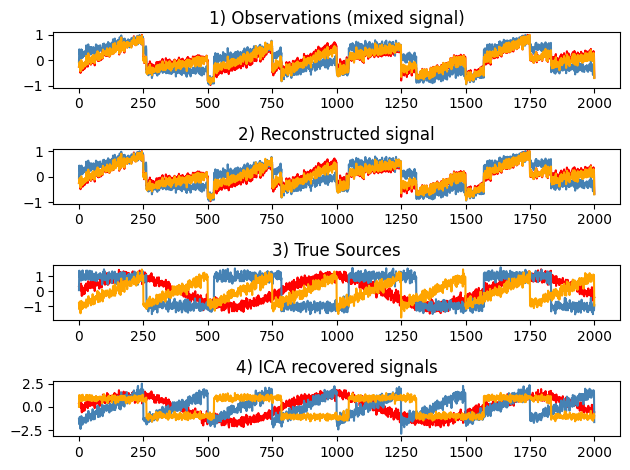

In [197]:
plt.figure()

models = [X, X_reconstructed, S, S_reconstructed]
names = ['1) Observations (mixed signal)',
         '2) Reconstructed signal',
         '3) True Sources',
         '4) ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

ICA nie jest w stanie odtworzyć kolejności i znaków sygnałów, dlatego na wykresach 2 i 3 mogą one mieć różne kolory i fazę. Jednak kształty przebiegów się pokrywają - można porównać wyniki dla kilku uruchomień algorytmu po usunięciu parametru `random_state` z konstruktora `ica`.

W kolejnym zadaniu sprawdzimy działanie ICA na sygnałach rzeczywistych. Znowu będziemy znać przebieg sygnałów składowych, lecz będą one dużo bardziej skomplikowane i porównanie przebiegów czasowych sygnałów oryginalnych i po rekonstrukcji nie będzie możliwe - sprawdzimy działanie algorytmu „na ucho”.